In [1]:
import sys, os
from collections import namedtuple
import csv
import ast
import re

from tqdm import tqdm

import openai, anthropic
import backoff
import tiktoken

from langchain.chat_models import ChatOpenAI
from langchain.chat_models import ChatAnthropic
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

In [2]:
oai_api_key_file =       "path/to/openai_key"
anthropic_api_key_file = "path/to/anthropic_key"

with open(oai_api_key_file, "r") as api_key_fs:
    os.environ["OPENAI_API_KEY"] = api_key_fs.read().strip()
    
with open(anthropic_api_key_file, "r") as api_key_fs:
    os.environ["ANTHROPIC_API_KEY"] = api_key_fs.read().strip()

In [3]:
test_set_file = "../cc_4_0_licensed/python_builtins_swap.csv" # Path to test set

In [4]:
test_set = []
with open(test_set_file, "r") as in_fs:
    reader = csv.reader(in_fs)
    for i, row in enumerate(reader):
        if i == 0:
            continue # skip header
        example = {"prompt": row[0], "classes": ast.literal_eval(row[1]), "answer_index": int(row[2])}
        test_set.append(example)

In [6]:
prompt_template = \
"""
Consider the following Python programs:

Program 1:

{program_1}

Program 2:

{program_2}

Which program is more likely to be correct? Write only the number of the program and nothing else.
"""

In [26]:
batch_size = 20 # note: actual submitted batches are twice as big since each example is sumbitted in two variants
max_tokens_per_example = 4000 # Computed using tiktoken, not including the system prompt, assuming gpt-3.5-turbo-0301

In [13]:
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo-0301")

In [27]:
@backoff.on_exception(backoff.expo, Exception)
def chat_llm_batch(chat_model, batch_messages, **kwargs):
    return chat_model.generate(batch_messages, **kwargs)

def eval_chat_model_batch(chat_model, batch, switch_order):
    b_accuracy, b_num_valid = 0, 0
    batch_messages = []
    y_batch = []
    for example in batch:
        y = example["answer_index"]
        if switch_order:
            y = 1 - y
        x = prompt_template.format(
            program_1 = example["prompt"] + example["classes"][1-y].rstrip() + "\n",
            program_2 = example["prompt"] + example["classes"][y].rstrip() + "\n")
        if len(tokenizer.encode(x)) > max_tokens_per_example:
            # too long, skip
            continue
        x_messages = [
            SystemMessage(content="You are a helpful assistant."),
            HumanMessage(content=x)]
        batch_messages.append(x_messages)
        y_batch.append(y)
    llm_batch_response = chat_llm_batch(chat_model, batch_messages)
    for i, gen in enumerate(llm_batch_response.generations):
        match = re.search(r'(\d+)', gen[0].text)
        if match is None:
            continue
        gen_class = int(match.group(1)) - 1 # generated class ids should be returned by the llm in the 1, 2 range
        if (gen_class < 0) or (gen_class > 1):
            continue
        if gen_class == y:
            b_accuracy += 1
        b_num_valid += 1
    return b_accuracy, b_num_valid   

def eval_chat_model(chat_model, test_set):
    raw_total_accuracy, num_valid, num_examples = 0, 0, 0
    batch = []
    for i in tqdm(range(len(test_set) + 1)):
        if (i >= len(test_set)) or (len(batch) >= batch_size):
            b_accuracy, b_num_valid = eval_chat_model_batch(chat_model, batch, False)
            raw_total_accuracy += b_accuracy
            num_valid += b_num_valid
            num_examples += len(batch)
            b_accuracy, b_num_valid = eval_chat_model_batch(chat_model, batch, True)
            raw_total_accuracy += b_accuracy
            num_valid += b_num_valid
            num_examples += len(batch)
            batch = []
        if i < len(test_set):
            batch.append(test_set[i])
    total_accuracy = float(raw_total_accuracy) / num_examples
    total_accuracy_on_valid = float(raw_total_accuracy) / num_valid
    return {
        "raw_total_accuracy": raw_total_accuracy,
        "total_accuracy": total_accuracy,
        "total_accuracy_on_valid": total_accuracy_on_valid,
        "num_valid": num_valid,
        "num_examples": num_examples}

In [15]:
eval_results = {}

In [16]:
model_name = "claude-instant-v1.1"
print(model_name)
chat = ChatAnthropic(model=model_name, temperature=0.0)
chat_eval = eval_chat_model(chat, test_set)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

claude-instant-v1.1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [19:59<00:00,  1.20s/it]

{'raw_total_accuracy': 206, 'total_accuracy': 0.103, 'total_accuracy_on_valid': 0.103, 'num_valid': 2000, 'num_examples': 2000}
----


In [17]:
model_name = "claude-v1.3"
print(model_name)
chat = ChatAnthropic(model=model_name, temperature=0.0)
chat_eval = eval_chat_model(chat, test_set)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

claude-v1.3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [44:04<00:00,  2.64s/it]

{'raw_total_accuracy': 350, 'total_accuracy': 0.175, 'total_accuracy_on_valid': 0.175, 'num_valid': 2000, 'num_examples': 2000}
----


In [19]:
model_name="gpt-3.5-turbo-0301"
chat = ChatOpenAI(model_name=model_name, temperature=0.0)
print(model_name)
chat_eval = eval_chat_model(chat, test_set)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

gpt-3.5-turbo-0301


  0%|                                                                                                                                                                                     | 0/1001 [00:00<?, ?it/s]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c972c4c81559af3b5b87a200dcc30cfb in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 733f3116a1f0e13399dc761d63e86d5b in your message.).
R

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 501/1001 [1:05:28<1:23:20, 10.00s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2020fb8629e9fd48eeb974cc62481fb1 in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID af7bb2e3b582bddbcd48ea164b36fb2d in your message.).
 

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID efe51d859e825291eccc62b2e2796018 in your message.).
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 901/1001 [1:39:31<06:21,  3.82s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 39b0247737cc2c2050ac03dcdc2c5269 in your message.).
R

{'raw_total_accuracy': 67, 'total_accuracy': 0.0335, 'total_accuracy_on_valid': 0.0393885949441505, 'num_valid': 1701, 'num_examples': 2000}
----


In [28]:
model_name="gpt-4-0314"
chat = ChatOpenAI(model_name=model_name, temperature=0.0)
print(model_name)
chat_eval = eval_chat_model(chat, test_set)
print(chat_eval)
print("----")
eval_results[model_name] = chat_eval

gpt-4-0314


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 741/1001 [43:15<33:26,  7.72s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Fri, 19 May 2023 11:39:29 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c9c07a8dc0b0abf-MAN', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=8

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [1:38:48<00:00,  5.92s/it]

{'raw_total_accuracy': 37, 'total_accuracy': 0.0185, 'total_accuracy_on_valid': 0.018518518518518517, 'num_valid': 1998, 'num_examples': 2000}
----


In [69]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [30]:
out_file_name = "eval_chat_llms_results.json"

In [33]:
with open(out_file_name, "w") as out_fs:
    json.dump(eval_results, out_fs)

In [34]:
plt.rcParams.update({'font.size': 12.0})
plt.rcParams.update({'figure.titlesize': 'small'})
plt.rcParams.update({'legend.fontsize': 'small'})

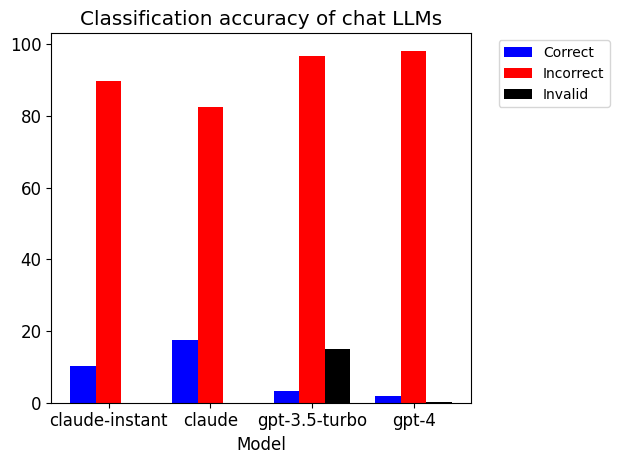

In [73]:
title = "Classification accuracy of chat LLMs"

model_names_succinct = ["-".join(model_name.split("-")[:-1]) for model_name in eval_results.keys()]
ind = np.arange(len(model_names_succinct))
width = 0.25

pos_vals = [100.0 * eval_results[model_name]['total_accuracy'] for model_name in eval_results.keys()]
plt.bar(ind, pos_vals, width, label='Correct', color='blue')

neg_vals = [100.0 * (eval_results[model_name]['num_examples'] - eval_results[model_name]['raw_total_accuracy']) / eval_results[model_name]['num_examples'] for model_name in eval_results.keys()]
plt.bar(ind+width, neg_vals, width, label='Incorrect', color='red')

invalid_vals = [100.0 * (1.0 - (eval_results[model_name]['num_valid'] / eval_results[model_name]['num_examples'])) for model_name in eval_results.keys()]
plt.bar(ind+2*width, invalid_vals, width, label='Invalid', color='black')

plt.xlabel("Model")
plt.title(title)
plt.xticks(ind + (width), model_names_succinct)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

plt.savefig(Path("./", "chat_llms_classsification_plot.svg"), format="svg")
plt.savefig(Path("./", "chat_llms_classsification_plot.png"), format="png")
plt.savefig(Path("./", "chat_llms_classsification_plot.pdf"), format="pdf")

In [71]:
eval_results

{'claude-instant-v1.1': {'raw_total_accuracy': 206,
  'total_accuracy': 0.103,
  'total_accuracy_on_valid': 0.103,
  'num_valid': 2000,
  'num_examples': 2000},
 'claude-v1.3': {'raw_total_accuracy': 350,
  'total_accuracy': 0.175,
  'total_accuracy_on_valid': 0.175,
  'num_valid': 2000,
  'num_examples': 2000},
 'gpt-3.5-turbo-0301': {'raw_total_accuracy': 67,
  'total_accuracy': 0.0335,
  'total_accuracy_on_valid': 0.0393885949441505,
  'num_valid': 1701,
  'num_examples': 2000},
 'gpt-4-0314': {'raw_total_accuracy': 37,
  'total_accuracy': 0.0185,
  'total_accuracy_on_valid': 0.018518518518518517,
  'num_valid': 1998,
  'num_examples': 2000}}

In [74]:
from IPython.display import Image

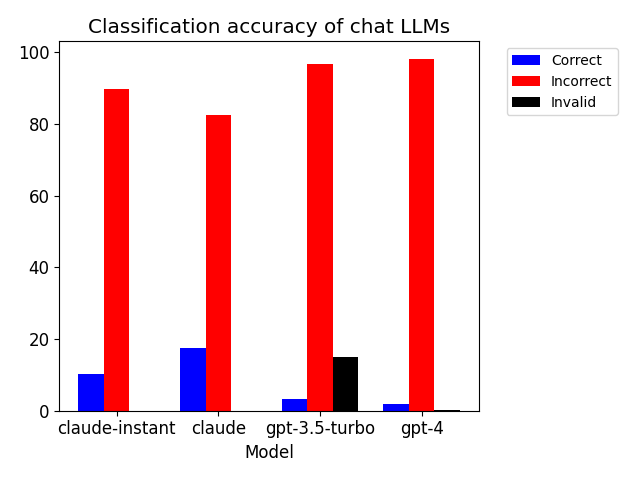

In [75]:
Image("./chat_llms_classsification_plot.png")